<a href="https://colab.research.google.com/github/claudio1975/Insurance_Cross_Sell_Prediction_Web_App/blob/main/insurance_cross_selling_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Insurance Cross Selling Prediction

# Prepare Workspace

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 28.9 MB/s 


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
import shap

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
from google.colab import files 
uploaded = files.upload()

Saving train.csv to train.csv


In [5]:
df = pd.read_csv('train.csv')

# Data Set Overview

In [6]:
print(df.shape)

(381109, 12)


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
None


In [8]:
print(df.columns)

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


In [9]:
print(df.head())

   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0  


# Data Cleaning

In [10]:
# Delete duplicate columns
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

(381109, 12)


In [11]:
# Delete duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)

(381109, 12)


In [12]:
# Check missing values both to numeric features and categorical features 
missing = df.isnull().sum()/df.shape[0]*100
missing

id                      0.0
Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
Response                0.0
dtype: float64

In [13]:
# Formatting features
df['Driving_License'] = df['Driving_License'].astype('object')
df['Region_Code'] = df['Region_Code'].astype('object')
df['Previously_Insured'] = df['Previously_Insured'].astype('object')
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('object')
df['Response'] = df['Response'].astype('object')

# Summary Statistics

In [14]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype=='object']
df[obj_cols].describe().T

,count,unique,top,freq
Gender,381109,2,Male,206089
Driving_License,381109,2,1,380297
Region_Code,381109.0,53.0,28.0,106415.0
Previously_Insured,381109,2,0,206481
Vehicle_Age,381109,3,1-2 Year,200316
Vehicle_Damage,381109,2,Yes,192413
Policy_Sales_Channel,381109.0,155.0,152.0,134784.0
Response,381109,2,0,334399


In [15]:
# Summarize attribute distributions for data type of variables
num_cols = [var for var in df.columns if df[var].dtype!='object']
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0


In [16]:
# Split data set between target variable and features
X_full = df.copy()
y = X_full.Response
X_full.drop(['Response'], axis=1, inplace=True)

# Target Variable Analysis

In [17]:
# Summarize the class distribution 
count = pd.crosstab(index = y, columns="count")
percentage = pd.crosstab(index = y, columns="frequency")/pd.crosstab(index = y, columns="frequency").sum()
pd.concat([count, percentage], axis=1)

col_0,count,frequency
Response,,
0,334399,0.877437
1,46710,0.122563


In [18]:
def piechart(data, col1, col2):
    # Plot the target variable 
    plt.rcParams['figure.figsize']=(15,5)
    plt.subplot(1,2,1)
    data.groupby(col1).count()[col2].plot(kind='pie',autopct='%.0f%%').set_title("Pie {} Variable Distribution".format(col1))
    plt.subplot(1,2,2)
    sns.countplot(x=data[col1], data=data).set_title("Barplot {} Variable Distribution".format(col1))
    plt.show()

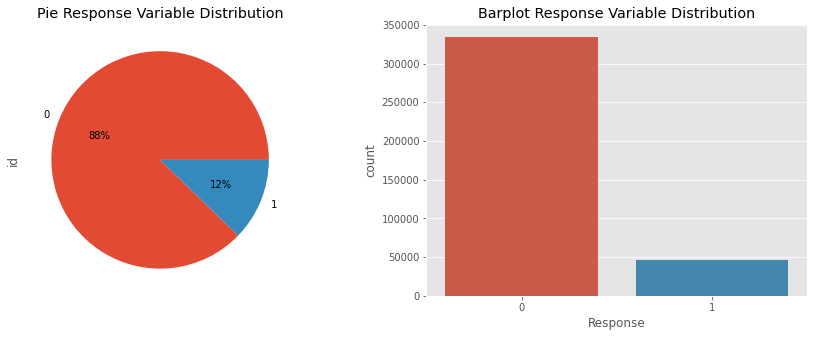

In [19]:
col1 = 'Response'
col2 = 'id'
piechart(df, col1, col2)

# Numerical Features Analysis

### Analysis for numerical features (univariate analysis, bivariate analysis)

In [20]:
# Select numerical columns
X_full.drop(['id'], axis=1, inplace=True)
numerical_cols = [var for var in X_full.columns if X_full[var].dtype in ['float64','int64']]

In [21]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['Age', 'Annual_Premium', 'Vintage'], dtype='object')

### Visualization

In [22]:
def plot_num(data, var):
    plt.rcParams['figure.figsize']=(15,5)
    plt.subplot(1,3,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(1,3,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(1,3,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.show()

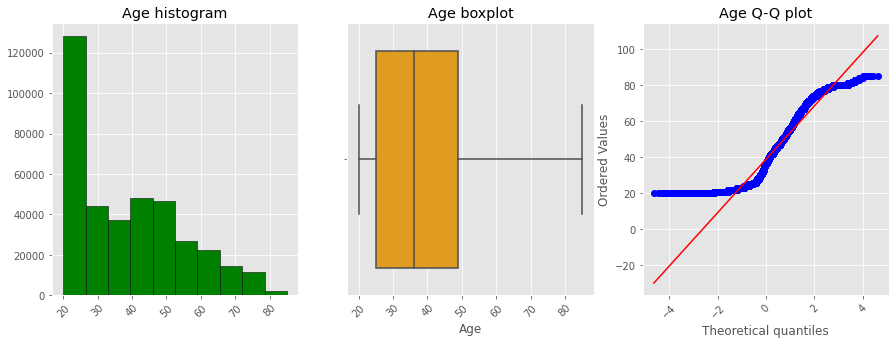

In [23]:
plot_num(num, var='Age')

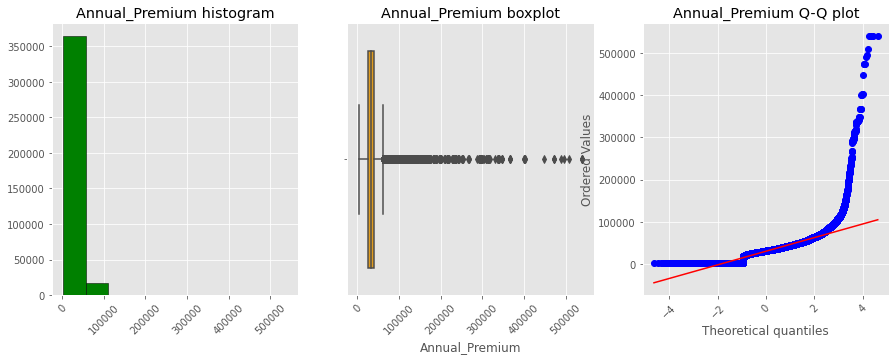

In [24]:
plot_num(num, var='Annual_Premium')

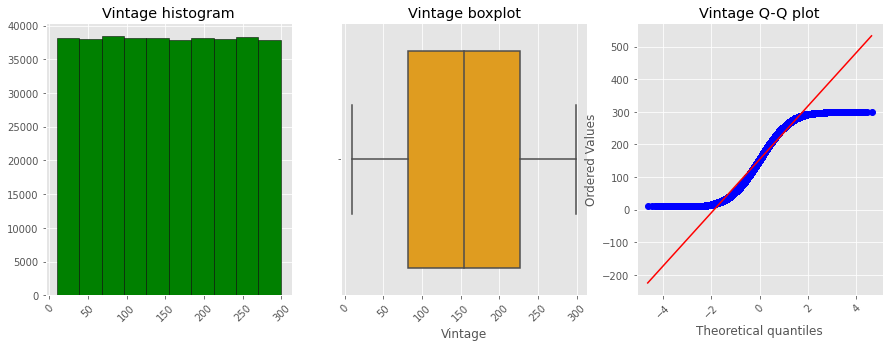

In [25]:
plot_num(num, var='Vintage')

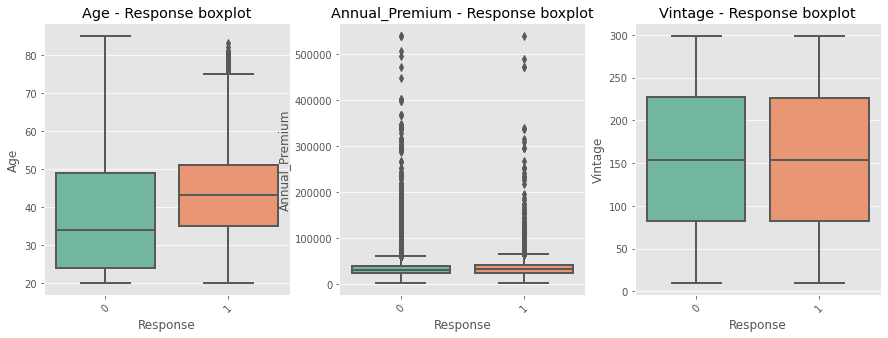

In [26]:
# new subset for a bivariate analysis
num2 = pd.concat([y,num], axis=1)
plt.rcParams['figure.figsize']=(15,5)
plt.subplot(1,3,1)
sns.boxplot(y='Age', x=y, data=num2, linewidth=2, palette="Set2")
plt.title('{} - Response boxplot'.format('Age'))
plt.xticks(rotation=45)
        
plt.subplot(1,3,2)
sns.boxplot(y='Annual_Premium', x=y, data=num2, linewidth=2, palette="Set2")
plt.title('{} - Response boxplot'.format('Annual_Premium'))
plt.xticks(rotation=45)
        
plt.subplot(1,3,3)
sns.boxplot(y='Vintage', x=y, data=num2, linewidth=2, palette="Set2")
plt.title('{} - Response boxplot'.format('Vintage'))
plt.xticks(rotation=45)
    
plt.show()

### Statistical Analysis

In [27]:
# Univariate analysis looking at Mean, Standard Deviation, Skewness and Kurtosis
for col in num:
    print(col,
        '\nMean :', np.mean(num[col]),  
        '\nVariance :', np.var(num[col]),
        '\nStandard Deviation :', np.var(num[col]**0.5), 
        '\nSkewness :', stats.skew(num[col]), 
        '\nKurtosis :', stats.kurtosis(num[col]))

Age 
Mean : 38.822583565331705 
Variance : 240.609445034806 
Standard Deviation : 1.4713433772287088 
Skewness : 0.6725363506891485 
Kurtosis : -0.5656633888102887
Annual_Premium 
Mean : 30564.389581458323 
Variance : 296291929.5669131 
Standard Deviation : 3357.409308330456 
Skewness : 1.7660802637778974 
Kurtosis : 34.00410682771704
Vintage 
Mean : 154.34739667654136 
Variance : 7000.86868079634 
Standard Deviation : 14.1050642955642 
Skewness : 0.003029504966164472 
Kurtosis : -1.2006880332858327


# Categorical Features Analysis

### Analysis for categorical features (univariate analysis, bivariate analysis)

In [28]:
# let's have a look at how many labels for categorical features
for col in X_full.columns:
    if X_full[col].dtype =="object":
        print(col, ': ', len(X_full[col].unique()), ' labels')

Gender :  2  labels
Driving_License :  2  labels
Region_Code :  53  labels
Previously_Insured :  2  labels
Vehicle_Age :  3  labels
Vehicle_Damage :  2  labels
Policy_Sales_Channel :  155  labels


In [29]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [var for var in X_full.columns if
                    X_full[var].nunique() <= 15 and 
                    X_full[var].dtype == "object"]

In [30]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns

Index(['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
       'Vehicle_Damage'],
      dtype='object')

### Visualization

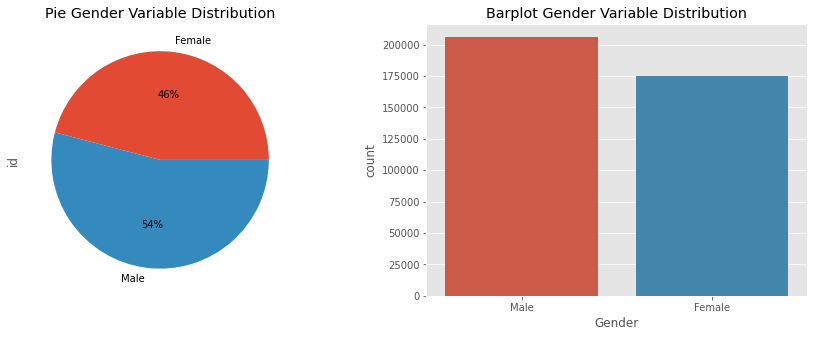

In [31]:
piechart(df, col1='Gender', col2='id')

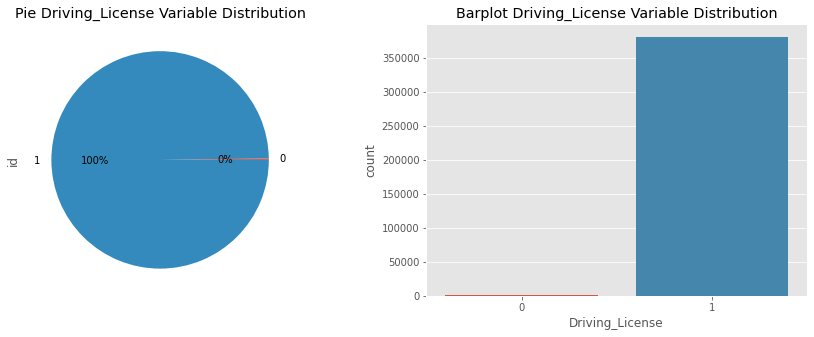

In [32]:
piechart(df, col1='Driving_License', col2='id')

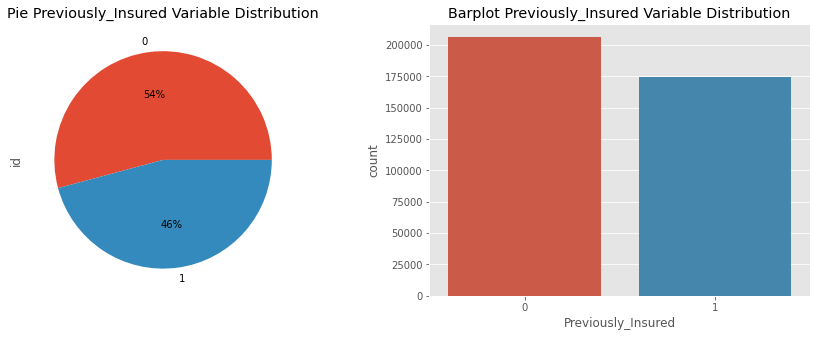

In [33]:
piechart(df, col1='Previously_Insured', col2='id')

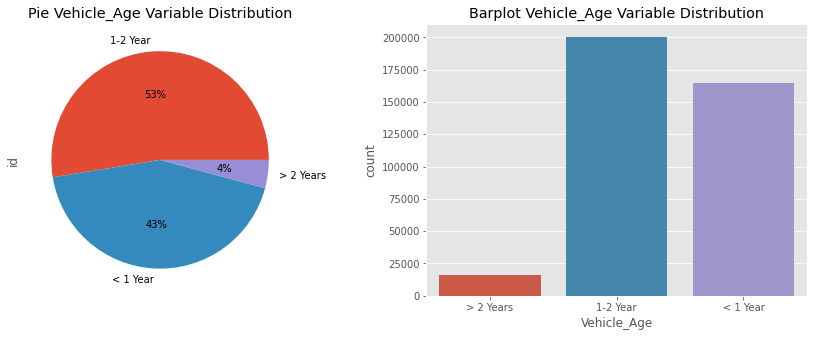

In [34]:
piechart(df, col1='Vehicle_Age', col2='id')

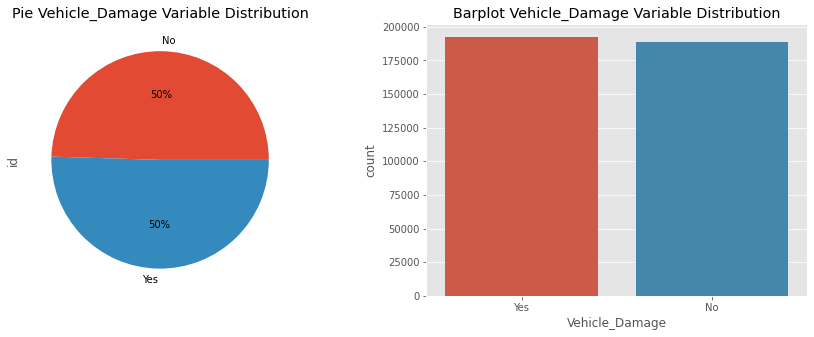

In [35]:
piechart(df, col1='Vehicle_Damage', col2='id')

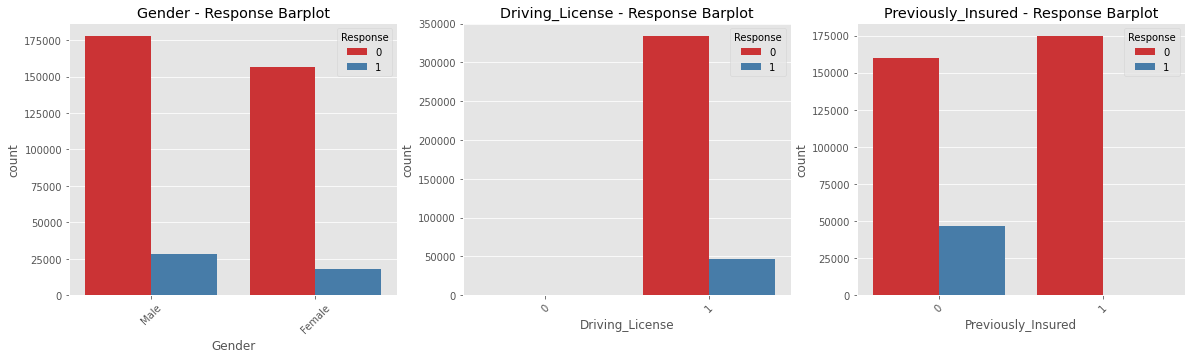

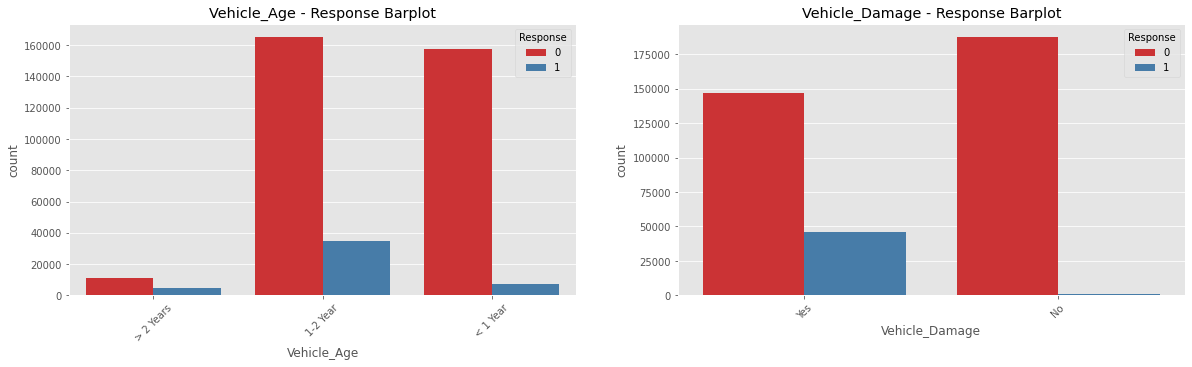

In [36]:
# new subset for a bivariate analysis
cat2 = pd.concat([y,cat], axis=1)
plt.rcParams['figure.figsize']=(20,5)
plt.subplot(1,3,1)
sns.countplot(x=cat2['Gender'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Gender'))
plt.xticks(rotation=45)
        
plt.subplot(1,3,2)
sns.countplot(x=cat2['Driving_License'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Driving_License'))
plt.xticks(rotation=45)
        
plt.subplot(1,3,3)
sns.countplot(x=cat2['Previously_Insured'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Previously_Insured'))
plt.xticks(rotation=45)

plt.show()

plt.rcParams['figure.figsize']=(20,5)
plt.subplot(1,2,1)
sns.countplot(x=cat2['Vehicle_Age'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Vehicle_Age'))
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.countplot(x=cat2['Vehicle_Damage'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Vehicle_Damage'))
plt.xticks(rotation=45)
    
plt.show()

### Statistical Analysis

In [37]:
# Univariate analysis looking at frequency
for col in cat:
    count = pd.crosstab(index = cat[col], columns="count")
    percentage = pd.crosstab(index = cat[col], columns="frequency")/pd.crosstab(index = cat[col], columns="frequency").sum()
    tab = pd.concat([count, percentage], axis=1)
    print('\n',tab)


 col_0    count  frequency
Gender                   
Female  175020   0.459239
Male    206089   0.540761

 col_0             count  frequency
Driving_License                   
0                   812   0.002131
1                380297   0.997869

 col_0                count  frequency
Previously_Insured                   
0                   206481    0.54179
1                   174628    0.45821

 col_0         count  frequency
Vehicle_Age                   
1-2 Year     200316   0.525613
< 1 Year     164786   0.432385
> 2 Years     16007   0.042001

 col_0            count  frequency
Vehicle_Damage                   
No              188696   0.495123
Yes             192413   0.504877


# Pre-Processing

### Numerical Features Pre-Processing

In [38]:
num_o = num.copy()

In [39]:
# outliers correction
for col in num_o.columns:
    q75, q25 = np.percentile(num_o[col].dropna(), [75 ,25])
    iqr = q75 - q25 
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5) 
    num_o[col].mask(num_o[col]<min, min, inplace=True)
    num_o[col].mask(num_o[col]>max, max, inplace=True)

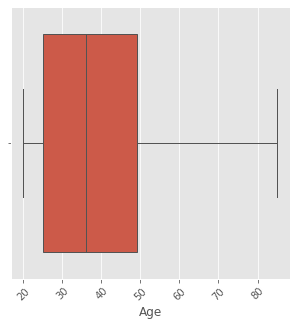

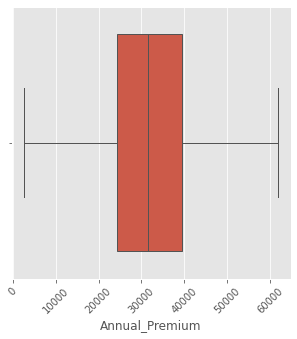

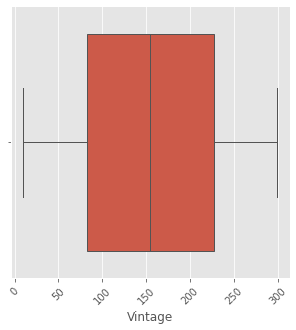

In [40]:
# check corrections
for col in num_o:
    plt.rcParams['figure.figsize']=(5,5)
    x=num_o[col]
    sns.boxplot(x,linewidth=1)
    plt.xticks(rotation=45)
    plt.show()

### Categorical Features Pre-Processing

In [41]:
# Transform in integer binary variables
y = y.astype('int')
cat2['Driving_License'] = cat2['Driving_License'].astype('int')
cat2['Previously_Insured'] = cat2['Previously_Insured'].astype('int')

In [42]:
cat2['Gender']=cat2['Gender'].map({'Female':0,'Male':1})
cat2['Vehicle_Damage']=cat2['Vehicle_Damage'].map({'No':0,'Yes':1})

In [43]:
# calculate the mean target value per category for each feature and capture the result in a dictionary 
Vehicle_Age_LABELS = cat2.groupby(['Vehicle_Age'])['Response'].mean().to_dict()
# replace for each feature the labels with the mean target values
cat2['Vehicle_Age'] = cat2['Vehicle_Age'].map(Vehicle_Age_LABELS)


In [44]:
# Look at the new subset
target_cat = cat2.drop(['Response'], axis=1)
target_cat.shape

(381109, 5)

In [45]:
target_cat.head()

,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage
0,1,1,0,0.293746,1
1,1,1,0,0.173755,0
2,1,1,0,0.293746,1
3,1,1,1,0.043705,0
4,0,1,1,0.043705,0


In [46]:
# Grasp all
X_all = pd.concat([num_o,target_cat], axis=1)

### Zero Variance Predictors

In [47]:
# Find features with variance equal zero 
to_drop = [col for col in X_all.columns if np.var(X_all[col]) == 0]
to_drop

[]

In [48]:
# Drop features 
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Correlated Predictors

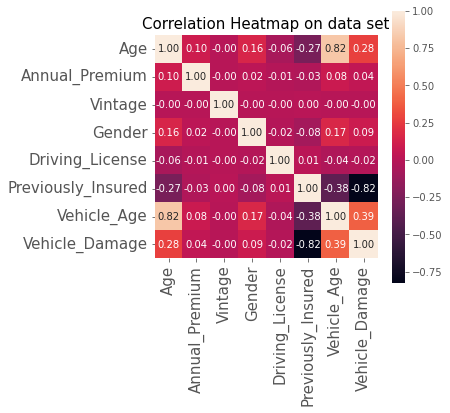

In [49]:
# Correlation 
corr_matrix = X_all_v.corr(method ='spearman')
sns.heatmap(corr_matrix, square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=15)
plt.yticks(fontsize="15")
plt.xticks(fontsize="15")
plt.show()

In [50]:

# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.80)]
to_drop

['Vehicle_Age', 'Vehicle_Damage']

In [51]:
# Drop features 
X_all_c = X_all_v.drop(X_all_v[to_drop], axis=1)

In [52]:
X_all_c.head()

,Age,Annual_Premium,Vintage,Gender,Driving_License,Previously_Insured
0,44,40454.0,217,1,1,0
1,76,33536.0,183,1,1,0
2,47,38294.0,27,1,1,0
3,21,28619.0,203,1,1,1
4,29,27496.0,39,0,1,1


In [53]:
# Normalization 
scaling = MinMaxScaler()
# Normalization of numerical features
num_sc = pd.DataFrame(scaling.fit_transform(X_all_c[['Age','Annual_Premium','Vintage']]), columns= ['Age','Annual_Premium','Vintage'])
# Grasp all
X_all_sc = pd.concat([num_sc, X_all_c[['Gender','Driving_License','Previously_Insured']]], axis=1)

In [54]:
# Split data set
# Break off train and test set from data
X_train, X_test, y_train, y_test = train_test_split(X_all_sc, y, train_size=0.8, test_size=0.2,stratify=y,
                                                                random_state=0)

# Spot check Models

In [55]:
start = time.time()
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(random_state=0)))
models.append(('KNB', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('HGBM', HistGradientBoostingClassifier(random_state=0)))

results_tr = []
results_t = []
names = []
score = []
skf = StratifiedKFold(n_splits=5,random_state=0, shuffle=True)
for (name, model) in models:
    param_grid = {}
    my_model = GridSearchCV(model,param_grid,cv=skf)
    my_model.fit(X_train, y_train)
    predictions_tr = my_model.predict_proba(X_train)[:, 1]
    predictions_t = my_model.predict_proba(X_test)[:, 1]
    auc_train = roc_auc_score(y_train, predictions_tr)  
    auc_test = roc_auc_score(y_test, predictions_t) 
    results_tr.append(auc_train)
    results_t.append(auc_test)
    
    names.append(name)
    f_dict = {
        'model': name,
        'auc_train': auc_train,
        'auc_test': auc_test
    }
    score.append(f_dict)   

stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 81.78854608535767s


In [56]:
# Look at the auc score for each model and for each sub set
score = pd.DataFrame(score, columns = ['model','auc_train','auc_test'])
score

,model,auc_train,auc_test
0,LR,0.779368,0.778922
1,KNB,0.909546,0.723211
2,GNB,0.805027,0.803807
3,HGBM,0.832758,0.826070


Spot Check Models


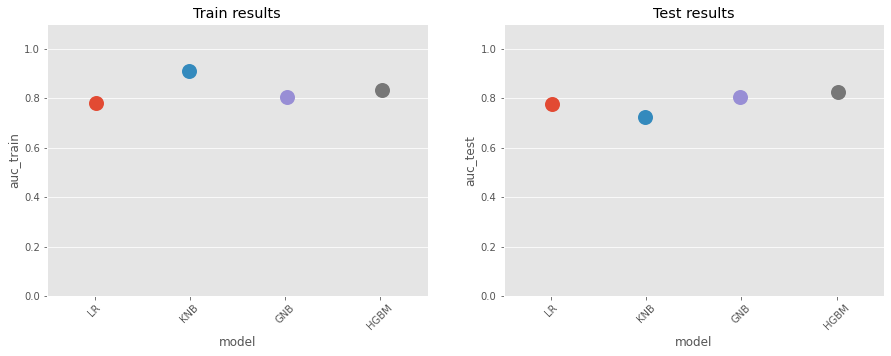

In [57]:
# Plot results for a graphical comparison
print("Spot Check Models")
plt.rcParams['figure.figsize']=(15,5)
plt.figure()
plt.subplot(1,2,1)  
sns.stripplot(x="model", y="auc_train",data=score,size=15)
plt.xticks(rotation=45)
plt.title('Train results')
axes = plt.gca()
axes.set_ylim([0,1.1])
plt.subplot(1,2,2)
sns.stripplot(x="model", y="auc_test",data=score,size=15)
plt.xticks(rotation=45)
plt.title('Test results')
axes = plt.gca()
axes.set_ylim([0,1.1])
plt.show()

# Tuning

In [58]:
start = time.time()
# cross validation
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
# define models and parameters
HGBM = HistGradientBoostingClassifier(random_state=0)
# define grid search
hyp_space = {"max_depth": [10,21],
             "learning_rate": [0.02,0.5],
             "max_bins": [80, 195]}
# Tuning and fit the model 
HGBM_model = GridSearchCV(HGBM, hyp_space, n_jobs=-1, cv=skf, scoring='roc_auc', error_score=0).fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop-start}s")

Training time: 74.1064887046814s


In [59]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score'] 
    std_score = results.cv_results_['std_test_score'] 
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [60]:
display(HGBM_model)

Best parameters are: {'learning_rate': 0.02, 'max_bins': 80, 'max_depth': 10}


0.827 + or -0.001 for the {'learning_rate': 0.02, 'max_bins': 80, 'max_depth': 10}
0.827 + or -0.001 for the {'learning_rate': 0.02, 'max_bins': 80, 'max_depth': 21}
0.827 + or -0.001 for the {'learning_rate': 0.02, 'max_bins': 195, 'max_depth': 10}
0.827 + or -0.001 for the {'learning_rate': 0.02, 'max_bins': 195, 'max_depth': 21}
0.821 + or -0.006 for the {'learning_rate': 0.5, 'max_bins': 80, 'max_depth': 10}
0.825 + or -0.002 for the {'learning_rate': 0.5, 'max_bins': 80, 'max_depth': 21}
0.825 + or -0.001 for the {'learning_rate': 0.5, 'max_bins': 195, 'max_depth': 10}
0.825 + or -0.001 for the {'learning_rate': 0.5, 'max_bins': 195, 'max_depth': 21}


# Modelling

In [61]:
# Model
HGBM_ = HistGradientBoostingClassifier(random_state=0,learning_rate=0.02, max_bins=80, max_depth= 10)
# Define the model
HGBM_model_ = HGBM_.fit(X_train, y_train)

In [62]:
start = time.time()
# prediction
predictions_tr = HGBM_model_.predict(X_train)
predictions_tr_ = pd.DataFrame(predictions_tr, columns=['y_train_pred'])
predictions_te = HGBM_model_.predict(X_test)
predictions_te_ = pd.DataFrame(predictions_te, columns=['y_test_pred'])
stop = time.time()
print(f"Training time: {stop-start}s")

Training time: 1.9640007019042969s


# Evaluation

In [63]:
auc_train = roc_auc_score(y_train, HGBM_model_.predict_proba(X_train)[:, 1])  
auc_test = roc_auc_score(y_test, HGBM_model_.predict_proba(X_test)[:, 1]) 

In [64]:
# metrics table
d1 = {'evaluation': ['AUC'],
     'model': ['HGBM'],
    'train': [auc_train],
    'test': [auc_test]
        }
df1 = pd.DataFrame(data=d1, columns=['model','evaluation','train','test'])
print('HGBM evaluation on cross-sell prediction')
df1

HGBM evaluation on cross-sell prediction


,model,evaluation,train,test
0,HGBM,AUC,0.829531,0.826265


In [65]:
def plot_roc_auc(y_test, y_score, classes):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.rcParams['figure.figsize']=(10,5)
    plt.plot(fpr, tpr,color='orange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1],color='brown', lw=2, linestyle='--' )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

ROC on train


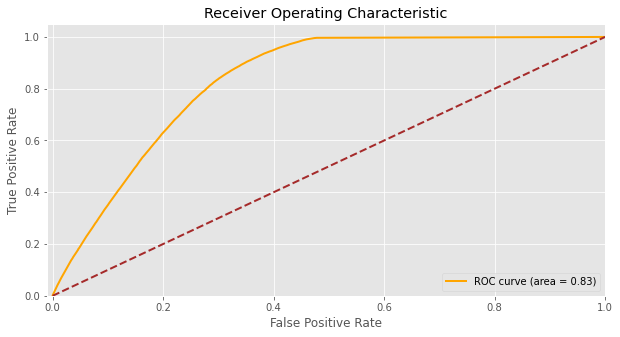

ROC on test


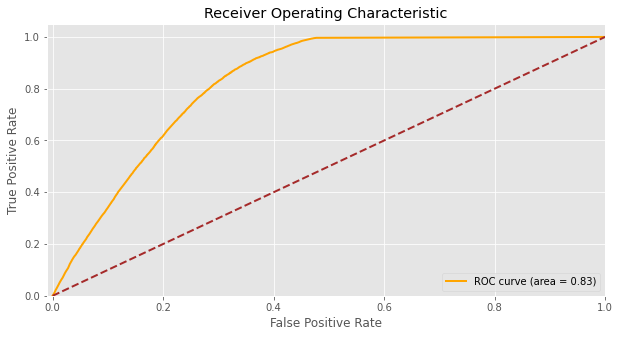

In [66]:
print('ROC on train')
plot_roc_auc(y_train, HGBM_model_.predict_proba(X_train)[:, 1], 2)
print('ROC on test')
plot_roc_auc(y_test, HGBM_model_.predict_proba(X_test)[:, 1], 2)

# Feature Importance

In [67]:
explainer = shap.TreeExplainer(HGBM_model_)
shap_values = explainer.shap_values(X_test)

HGBM SHAP BARPLOT on test Values


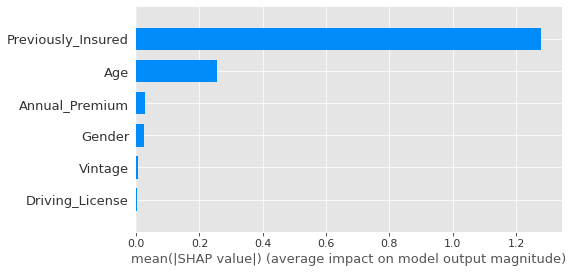

In [68]:
# Global SHAP on test
print("HGBM SHAP BARPLOT on test Values")
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar')